In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')

import pandas as pd
import seaborn as sns

sns.set_style('white')

# Table S1 - Sample overview

In [6]:
# Read sample overview.
samples = pd.read_csv('../data/raw/sb/samples.txt', sep='\t')

# Summarize metastases per mouse.
metastases = pd.read_csv('../data/raw/sb/metastases.txt', sep='\t')
metastases = metastases.ix[metastases['mouse'].isin(samples['mouse'])]

# Merge metastasis data with samples.
met_sites = (metastases.groupby('mouse')
                       .agg({'metastasis_site': lambda s: ', '.join(s)})
                       .reset_index())

samples = pd.merge(samples, met_sites, on='mouse', how='left')
samples.head()

,sample,t2onc_type,dnaseq_run,rnaseq_run,rnaseq_id,mouse,pathology_type,include_shearsplink,metastasis_site
0,11KOU012-R3,chr15-donor,SBecad,run120,1566_6_11KOU012-R3,11KOU012,"Spindle cell tumor, ILC",True,NaN
1,11KOU012-R5,chr15-donor,SBecad,run120,1566_7_11KOU012-R5,11KOU012,ILC,True,NaN
2,11KOU015,chr1-donor,SBecad,run120,1566_8_11KOU015,11KOU015,Spindle cell tumor,False,NaN
3,11KOU018,chr1-donor,SBecad,run120,1566_9_11KOU018,11KOU018,"Squamous, spindle cell, ILC",True,NaN
4,11KOU023,chr15-donor,SBecad,run120,1566_10_11KOU023,11KOU023,ILC,True,NaN


In [23]:
! mkdir -p ../reports/supplemental/tables/
samples.to_excel('../reports/supplemental/tables/table_s1_samples.xlsx', index=False)

# Table S2 - Candidate overview

In [2]:
from nbsupport import insertions as nb_ins

# Read insertions.
insertions = (pd.read_csv('../data/processed/sb/shear_splink/'
                          'all/insertions.cis.rbm.txt', sep='\t')
                .pipe(nb_ins.annotate_with_clonality))

# Summarize various statistics (including donor bias) for genes
# that were identified in the overall CIS analysis.
ranked_summary = nb_ins.gene_statistics(insertions)

ranked_summary.index.name = 'gene_name'
ranked_summary = ranked_summary.reset_index()

ranked_summary.head()

,gene_name,n_samples,mean_clonality,sense_fraction,sense_fraction_weighted
0,Arfip1,7,0.809442,0.636364,0.747715
1,Arid1a,14,0.399860,0.266667,0.181567
2,Asxl2,5,0.520660,0.500000,0.373262
3,Bach2,3,0.392943,1.000000,1.000000
4,Cblb,3,0.443457,0.000000,0.000000


In [3]:
import pybiomart

# Annotate location using biomart.
bm_dataset = pybiomart.Dataset(name='mmusculus_gene_ensembl',
                               host='http://www.ensembl.org')

bm_annotation = bm_dataset.query(
    attributes=['external_gene_name', 'chromosome_name',
                'start_position', 'end_position', 'strand'],
    use_attr_names=True)

bm_annotation = bm_annotation.rename(
    columns={'external_gene_name': 'gene_name'})

bm_annotation.head()

,gene_name,chromosome_name,start_position,end_position,strand
0,mt-Tp,MT,15356,15422,-1
1,mt-Tt,MT,15289,15355,1
2,mt-Cytb,MT,14145,15288,1
3,mt-Te,MT,14071,14139,-1
4,mt-Nd6,MT,13552,14070,-1


In [8]:
from nbsupport.morphology import test_strain_bias

strain_map = dict(zip(samples['sample'], samples['t2onc_type']))
insertions['t2onc_type'] = insertions['sample'].map(strain_map)

gene_bias = (
    test_strain_bias(
        insertions, value='gene_name', incl_neg=False,
        samples=samples.query('include_shearsplink == True'))
    .sort_values('p_value')
    .rename(columns={
            'pos_chr1-donor': 'n_samples_chr1_donor',
            'pos_chr15-donor': 'n_samples_chr15_donor',
            'p_value': 'donor_bias_pval',
            'q_value': 'donor_bias_qval'
        })
    .reset_index())

gene_bias.head()

,gene_name,n_samples_chr1_donor,n_samples_chr15_donor,donor_bias_pval,donor_bias_qval
0,Trp53bp2,12,3,0.001415,0.042451
1,Runx1,7,1,0.008175,0.122619
2,Ppp1r12a,11,30,0.022114,0.201767
3,Rgag1,4,0,0.026902,0.201767
4,Trp53,0,7,0.039225,0.235351


In [33]:
insertions_chr15 = pd.read_csv('../data/processed/sb/shear_splink/1868/'
                              'insertions.cis.rbm.txt', sep='\t')

insertions_chr1 = pd.read_csv('../data/processed/sb/shear_splink/1869/'
                              'insertions.cis.rbm.txt', sep='\t')

cis_bias = pd.DataFrame({'gene_name': ranked_summary['gene_name']})
cis_bias['cis_chr15_donor'] = cis_bias['gene_name'].isin(insertions_chr15['gene_name'])
cis_bias['cis_chr1_donor'] = cis_bias['gene_name'].isin(insertions_chr1['gene_name'])

cis_bias.head()

,gene_name,cis_chr15_donor,cis_chr1_donor
0,Arfip1,True,False
1,Arid1a,True,True
2,Asxl2,False,False
3,Bach2,False,False
4,Cblb,False,False


In [35]:
# Merge everything.
candidate_overview = (
    bm_annotation
    .pipe(pd.merge, right=ranked_summary, on='gene_name', how='right')
    .pipe(pd.merge, right=gene_bias, on='gene_name', how='left')
    .pipe(pd.merge, right=cis_bias, on='gene_name', how='left')
    .sort_values('n_samples', ascending=False))

# Re-order columns for legibility.
#candidate_overview = candidate_overview[
#    ['gene_name', 'chromosome_name', 'start_position', 'end_position',
#     'strand', 'n_samples', 'n_samples_chr15_donor', 'n_samples_chr1_donor',
#     'donor_bias_pval', 'donor_bias_qval', 'cis_chr15_donor', 'cis_chr1_donor',
#     'mean_clonality', 'sense_fraction_weighted']]

# Sort by frequency/clonality.
candidate_overview.sort_values(
    ['n_samples', 'mean_clonality'],
    ascending=False, inplace=True)

candidate_overview.head()

,gene_name,chromosome_name,start_position,end_position,strand,n_samples,mean_clonality,sense_fraction,sense_fraction_weighted,n_samples_chr1_donor,n_samples_chr15_donor,donor_bias_pval,donor_bias_qval,cis_chr15_donor,cis_chr1_donor
11,Fgfr2,7,130162451,133123350,-1,56,0.761385,0.513889,0.492919,26,30,0.305059,0.787224,True,True
10,Trps1,15,50654752,50890463,-1,51,0.618730,0.103704,0.055212,19,32,0.419853,0.787224,True,True
24,Ppp1r12a,10,108162400,108277575,1,41,0.552525,0.021277,0.003714,11,30,0.022114,0.201767,True,True
7,Myh9,15,77760587,77842175,-1,26,0.794418,0.108108,0.150643,8,18,0.249404,0.787224,True,True
22,Trp53bp2,1,182409172,182462432,1,15,0.755975,0.842105,0.868771,12,3,0.001415,0.042451,True,True


In [36]:
candidate_overview.to_excel('../reports/supplemental/tables/table_s2_candidate_overview.xlsx', index=False)

In [37]:
from IPython.display import display

# Print donor chromosome genes.
for chrom in ['1', '15']:
    print('Chromosome {}'.format(chrom))
    display(candidate_overview.query('chromosome_name == {!r}'.format(chrom)))

Chromosome 1


,gene_name,chromosome_name,start_position,end_position,strand,n_samples,mean_clonality,sense_fraction,sense_fraction_weighted,n_samples_chr1_donor,n_samples_chr15_donor,donor_bias_pval,donor_bias_qval,cis_chr15_donor,cis_chr1_donor
22,Trp53bp2,1,182409172,182462432,1,15,0.755975,0.842105,0.868771,12,3,0.001415,0.042451,True,True
16,Ppp1r12b,1,134754658,134955942,-1,7,0.442771,0.000000,0.000000,3,4,1.000000,1.000000,True,True


Chromosome 15


,gene_name,chromosome_name,start_position,end_position,strand,n_samples,mean_clonality,sense_fraction,sense_fraction_weighted,n_samples_chr1_donor,n_samples_chr15_donor,donor_bias_pval,donor_bias_qval,cis_chr15_donor,cis_chr1_donor
10,Trps1,15,50654752,50890463,-1,51,0.618730,0.103704,0.055212,19,32,0.419853,0.787224,True,True
7,Myh9,15,77760587,77842175,-1,26,0.794418,0.108108,0.150643,8,18,0.249404,0.787224,True,True


In [38]:
gene_bias.query('donor_bias_pval < 0.05')

,gene_name,n_samples_chr1_donor,n_samples_chr15_donor,donor_bias_pval,donor_bias_qval
0,Trp53bp2,12,3,0.001415,0.042451
1,Runx1,7,1,0.008175,0.122619
2,Ppp1r12a,11,30,0.022114,0.201767
3,Rgag1,4,0,0.026902,0.201767
4,Trp53,0,7,0.039225,0.235351


# Table S5 - Expression

In [144]:
sb_counts = pd.read_csv('../data/processed/sb/rnaseq/gene_counts.txt', sep='\t', index_col=0)
kb1p_counts = pd.read_csv('../data/processed/kb1p/gene_counts.txt', sep='\t', index_col=0)
pten_counts = pd.read_csv('../data/processed/pten/gene_counts.txt', sep='\t', index_col=0)

with pd.ExcelWriter('../reports/supplemental/tables/table_s5_expression.xlsx') as writer:
    sb_counts.to_excel(writer, sheet_name='SB samples')
    kb1p_counts.to_excel(writer, sheet_name='KB1P samples')
    pten_counts.to_excel(writer, sheet_name='EcadPten samples')

# Table S6 - Insertions

In [146]:
insertions = pd.read_csv('../data/processed/sb/shear_splink/all/insertions.txt', sep='\t')
insertions_annotated = pd.read_csv('../data/processed/sb/shear_splink/all/insertions.cis.rbm.txt', sep='\t')

cis_sites = pd.read_csv('../data/processed/sb/shear_splink/all/insertions.cis.sites.txt', sep='\t')
cis_insertions = pd.read_csv('../data/processed/sb/shear_splink/all/insertions.cis.txt', sep='\t')

cis_mapping = cis_insertions[['id', 'cis_id']]

with pd.ExcelWriter('../reports/supplemental/tables/table_s6_insertions.xlsx') as writer:
    insertions.to_excel(writer, sheet_name='insertions', index=False)
    cis_sites.to_excel(writer, sheet_name='cis_sites', index=False)
    cis_mapping.to_excel(writer, sheet_name='cis_mapping', index=False)
    insertions_annotated.to_excel(writer, sheet_name='insertions_annotated', index=False)

# Table SX - Subtype/strain bias

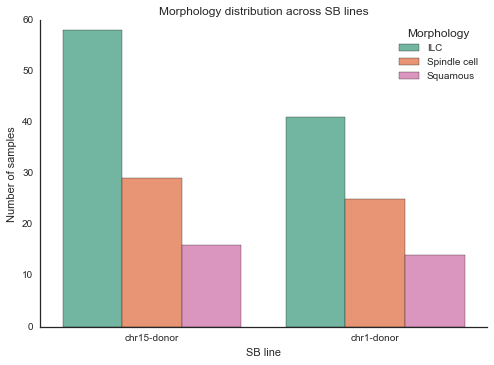

In [21]:
from matplotlib import pyplot as plt

from nbsupport.morphology import parse_morphology, MORPHOLOGY_ORDER, MORPHOLOGY_COLORS

# Read sample definition.
samples = pd.read_csv('../data/raw/sb/samples.txt', sep='\t')

# Define morphology annotation, melt to tidy (long) format.
morphology = (parse_morphology(samples)
              .reset_index()
              .pipe(pd.melt, id_vars='sample', var_name='morphology')
              .query('value == True')
              .drop('value', axis=1))

# Merge with strain info.
morphology = pd.merge(samples[['sample', 't2onc_type']], morphology, how='left')

# Plot.
fig, ax = plt.subplots()

sns.countplot(data=morphology, x='t2onc_type', hue='morphology',
              hue_order=MORPHOLOGY_ORDER, palette=MORPHOLOGY_COLORS)

ax.set_xlabel('SB line')
ax.set_ylabel('Number of samples')
ax.set_title('Morphology distribution across SB lines')
ax.legend(title='Morphology')
sns.despine(fig)

with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(4, 3))
   
    sns.countplot(data=morphology, x='t2onc_type', hue='morphology',
                  hue_order=MORPHOLOGY_ORDER, palette=MORPHOLOGY_COLORS)

    ax.set_xlabel('SB line')
    ax.set_ylabel('Number of samples')
    ax.set_title('Morphology distribution across SB lines')
    ax.legend(title='Morphology')
    sns.despine(fig)
    
    fig.savefig('../reports/supplemental/figures/fig_sx_donor_morphology.pdf', bbox_inches='tight')
    plt.close(fig)

In [11]:
from nbsupport.morphology import test_strain_bias

test_strain_bias(morphology, value='morphology', incl_neg=False)

,pos_chr1-donor,pos_chr15-donor,p_value,q_value
morphology,,,,
ILC,41,58,0.495455,0.676226
Spindle cell,25,29,0.584011,0.676226
Squamous,14,16,0.676226,0.676226


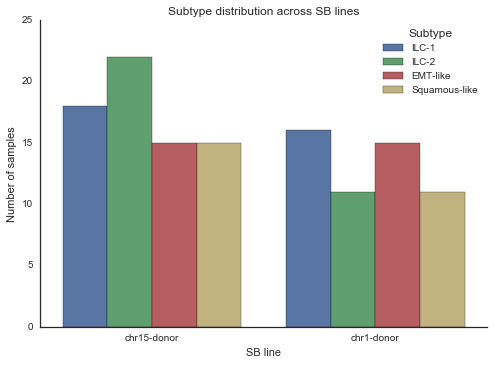

In [22]:
from nbsupport.expression.subtypes import SUBTYPE_ORDER, SUBTYPE_COLORS

# Read subtypes and merge with strain info.
subtypes = (pd.read_csv('../data/processed/sb/nmf/subtypes.txt', sep='\t')
              .rename(columns={'Unnamed: 0': 'sample'}))

subtypes = pd.merge(samples[['sample', 't2onc_type']], 
                    subtypes[['sample', 'subtype']],
                    on='sample', how='left')

# Plot.
fig, ax = plt.subplots()
sns.countplot(data=subtypes, x='t2onc_type', hue='subtype',
              hue_order=SUBTYPE_ORDER, palette=SUBTYPE_COLORS)
ax.set_xlabel('SB line')
ax.set_ylabel('Number of samples')
ax.set_title('Subtype distribution across SB lines')
ax.legend(title='Subtype')
sns.despine(fig)

with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(4, 3))
    
    sns.countplot(data=subtypes, x='t2onc_type', hue='subtype',
                  hue_order=SUBTYPE_ORDER, palette=SUBTYPE_COLORS)

    ax.set_xlabel('SB line')
    ax.set_ylabel('Number of samples')
    ax.set_title('Subtype distribution across SB lines')
    ax.legend(title='Subtype')
    sns.despine(fig)
    
    fig.savefig('../reports/supplemental/figures/fig_sx_donor_subtypes.pdf', bbox_inches='tight')
    plt.close(fig)

In [13]:
test_strain_bias(subtypes, value='subtype', incl_neg=False)

,pos_chr1-donor,pos_chr15-donor,p_value,q_value
subtype,,,,
EMT-like,15,15,0.403371,0.806742
ILC-1,16,18,0.684632,0.912843
ILC-2,11,22,0.220706,0.806742
Squamous-like,11,15,1.000000,1.000000
